In [13]:
import sys
import os

# Notebook 路徑: project/model/train.ipynb
project_root = os.path.dirname(os.path.abspath("__file__"))
model_dir = os.path.abspath(os.path.join(notebook_dir, "model"))  # 上一層就是專案根目錄

# 確保專案根目錄在 sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# 確保 model 資料夾在 sys.path
if model_dir not in sys.path:
    sys.path.insert(0, model_dir)

In [14]:
from chart_feature_extractor import getXYdata
X, Y, feature_name, all_song_name = getXYdata(is_use_cache=True)

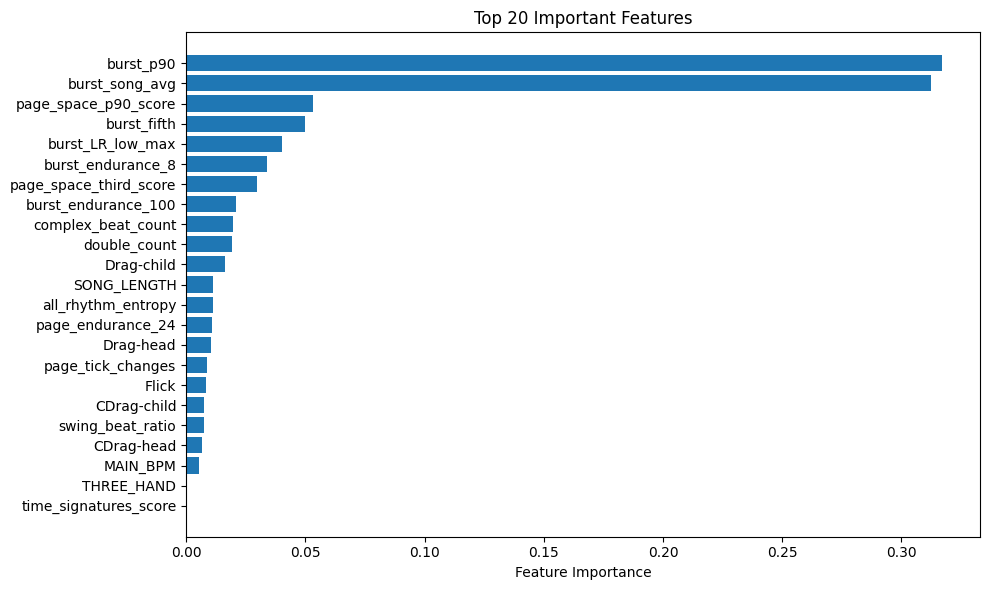

前 10 特徵名稱： ['burst_p90' 'burst_song_avg' 'page_space_p90_score' 'burst_fifth'
 'burst_LR_low_max' 'burst_endurance_8' 'page_space_third_score'
 'burst_endurance_100' 'complex_beat_count' 'double_count']
X_top_10_feature.shape = (643, 10)


In [17]:
# 特徵的重要性
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, Y)
# 假設你已經有：
# X: 原始特徵 (NumPy array)
# model.feature_importances_: 各特徵的重要性
# feature_name: 對應的特徵名稱（list 或 np.array）

# --- Step 1: 取得前 20 特徵畫圖用 ---
importance_array = model.feature_importances_
feature_name = np.array(feature_name)

# 找出前 20 名重要特徵的索引（由大到小）
top_20_indices = np.argsort(importance_array)[::-1][:]

# 畫圖
plt.figure(figsize=(10, 6))
plt.barh(feature_name[top_20_indices][::-1], importance_array[top_20_indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

# --- Step 2: 建立 X_top_10_feature ---
top_10_indices = top_20_indices[:10]  # 取出前10的 index
X_top_10_feature = X[:, top_10_indices]
top_10_feature_names = feature_name[top_10_indices]

# 可選：列出名稱與 shape 確認
print("前 10 特徵名稱：", top_10_feature_names)
print("X_top_10_feature.shape =", X_top_10_feature.shape)


In [24]:
# 找特徵相似的歌，沒什麼用
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


# 1. 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) * importance_array


song_id = 632

# 計算所有歌曲之間的歐氏距離（越小越相似）
dists = euclidean_distances(X_scaled, X_scaled)

# 對指定歌曲，找距離最小的其他歌曲（自己距離為 0，一定最小）
sort_idx = np.argsort(dists[song_id])  # 從小到大排序

# 列出前 8 首最相似（跳過自己）
for j in range(1, 9):
    print("最相似的歌曲名：", all_song_name[sort_idx[j]])


最相似的歌曲名： Hard Landing
最相似的歌曲名： Snow Blossom
最相似的歌曲名： そんなに私を期待きせないで
最相似的歌曲名： Dandelion Girls, Dandelion Boys
最相似的歌曲名： new world (Prod. Yunomi)
最相似的歌曲名： Brain Power
最相似的歌曲名： Victims of Will
最相似的歌曲名： Starchaser


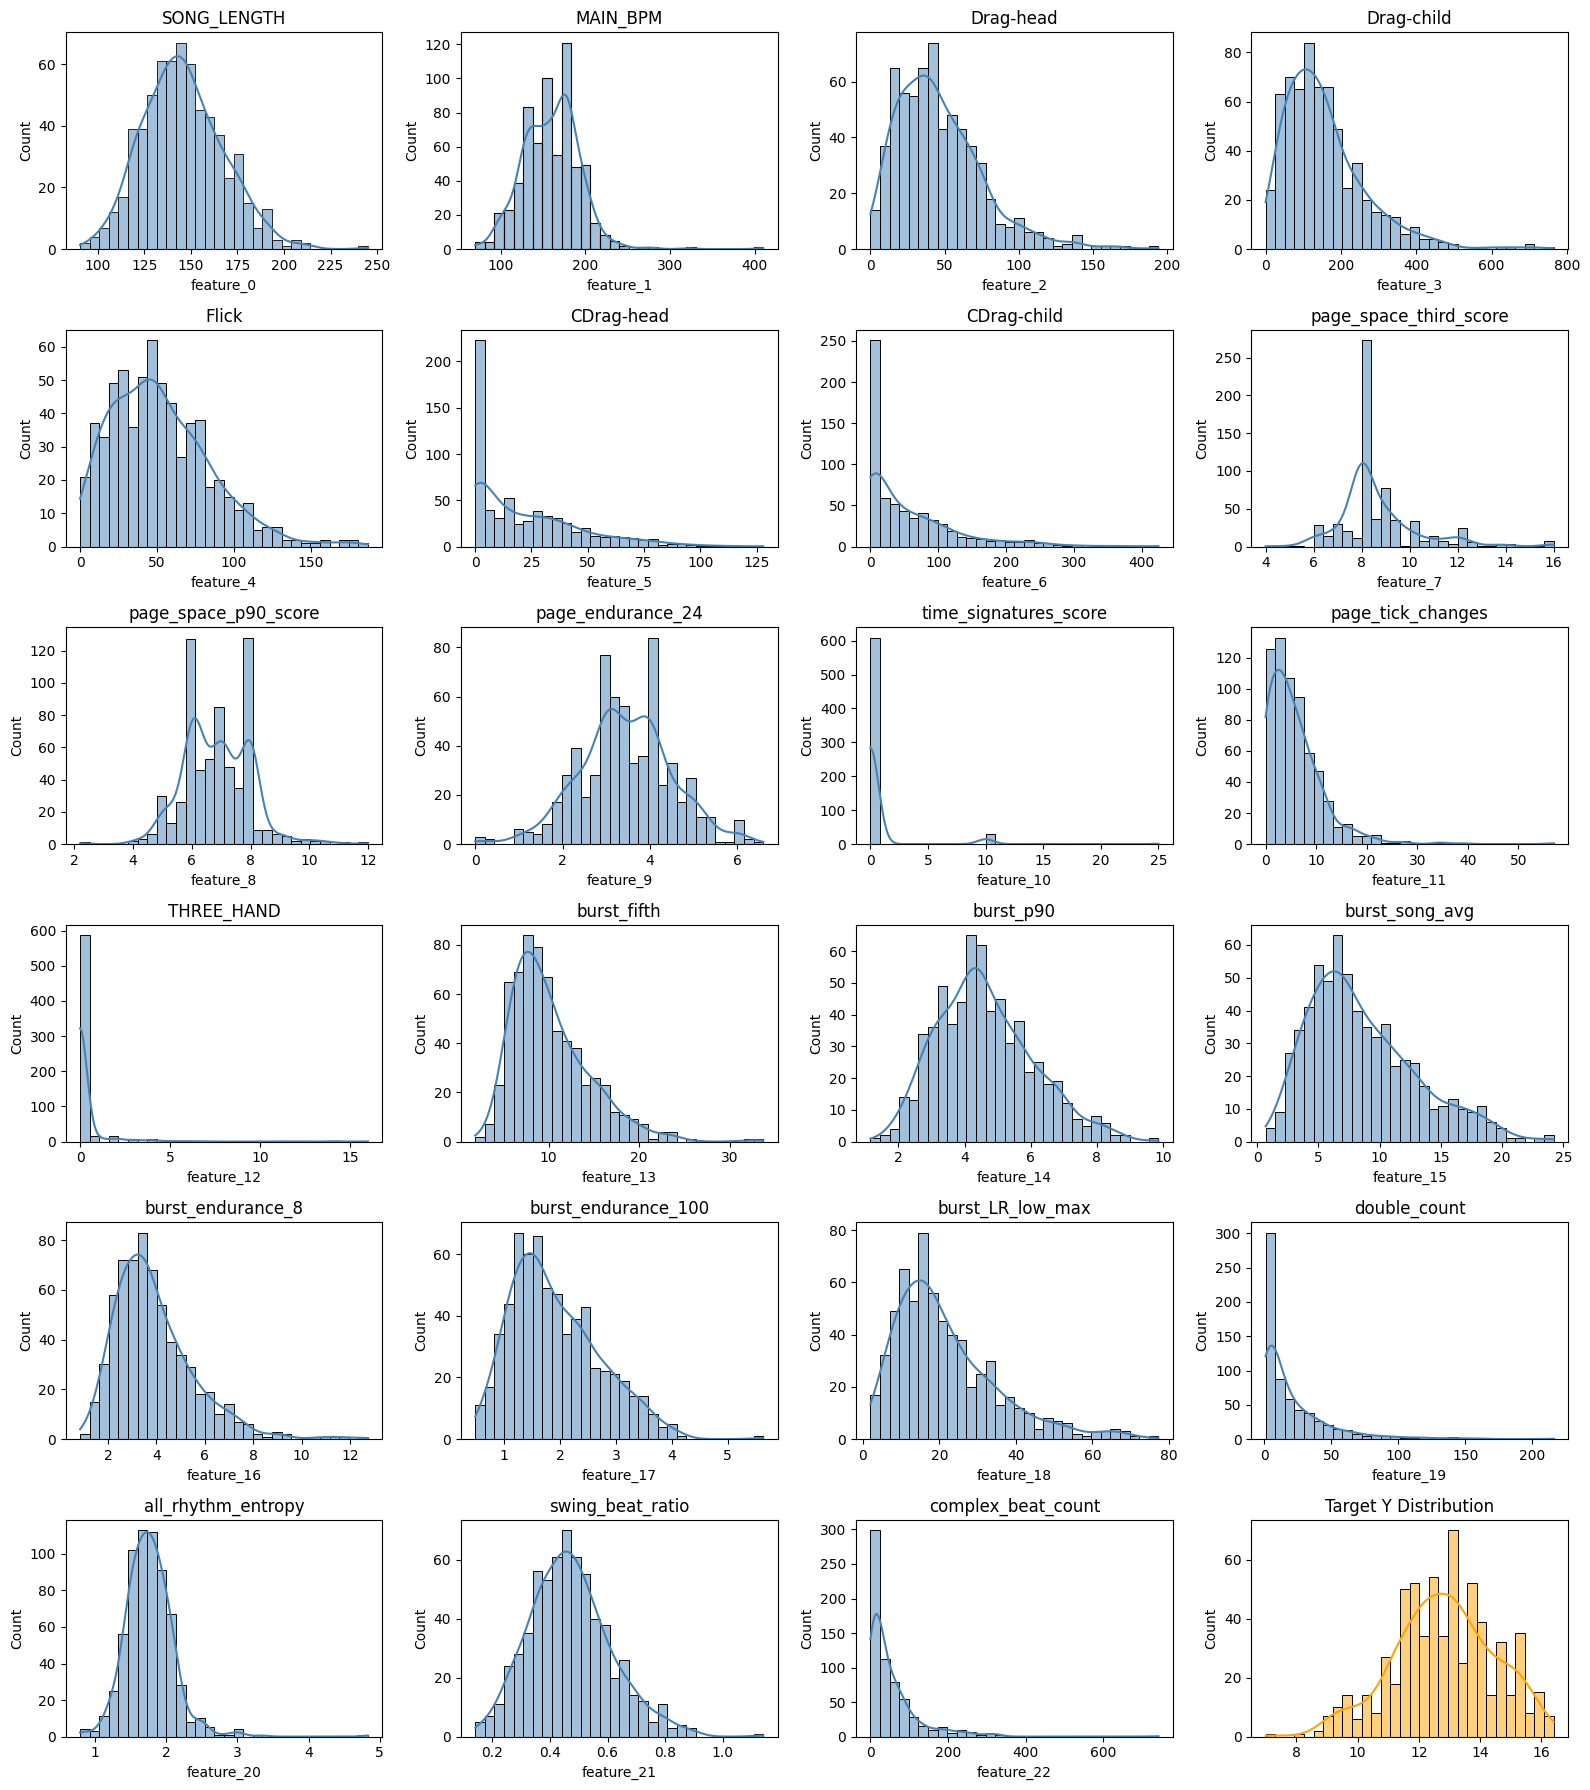

In [19]:
# 觀察特徵分布
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假設 X 是 numpy array，Y 是 numpy array（目標值）
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

n_features = df.shape[1]
n_cols = 4
n_rows = int(np.ceil((n_features + 1) / n_cols))  # +1 是為了放 Y

plt.figure(figsize=(n_cols * 4, n_rows * 3))

# 繪製 X 各特徵分布
for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=True, color="steelblue")
    plt.title(feature_name[i])
    plt.tight_layout()

# 繪製 Y 分布
plt.subplot(n_rows, n_cols, n_features + 1)
sns.histplot(Y, bins=30, kde=True, color="orange")
plt.title("Target Y Distribution")
plt.tight_layout()

plt.show()


376	DON'T STOP ROCKIN'


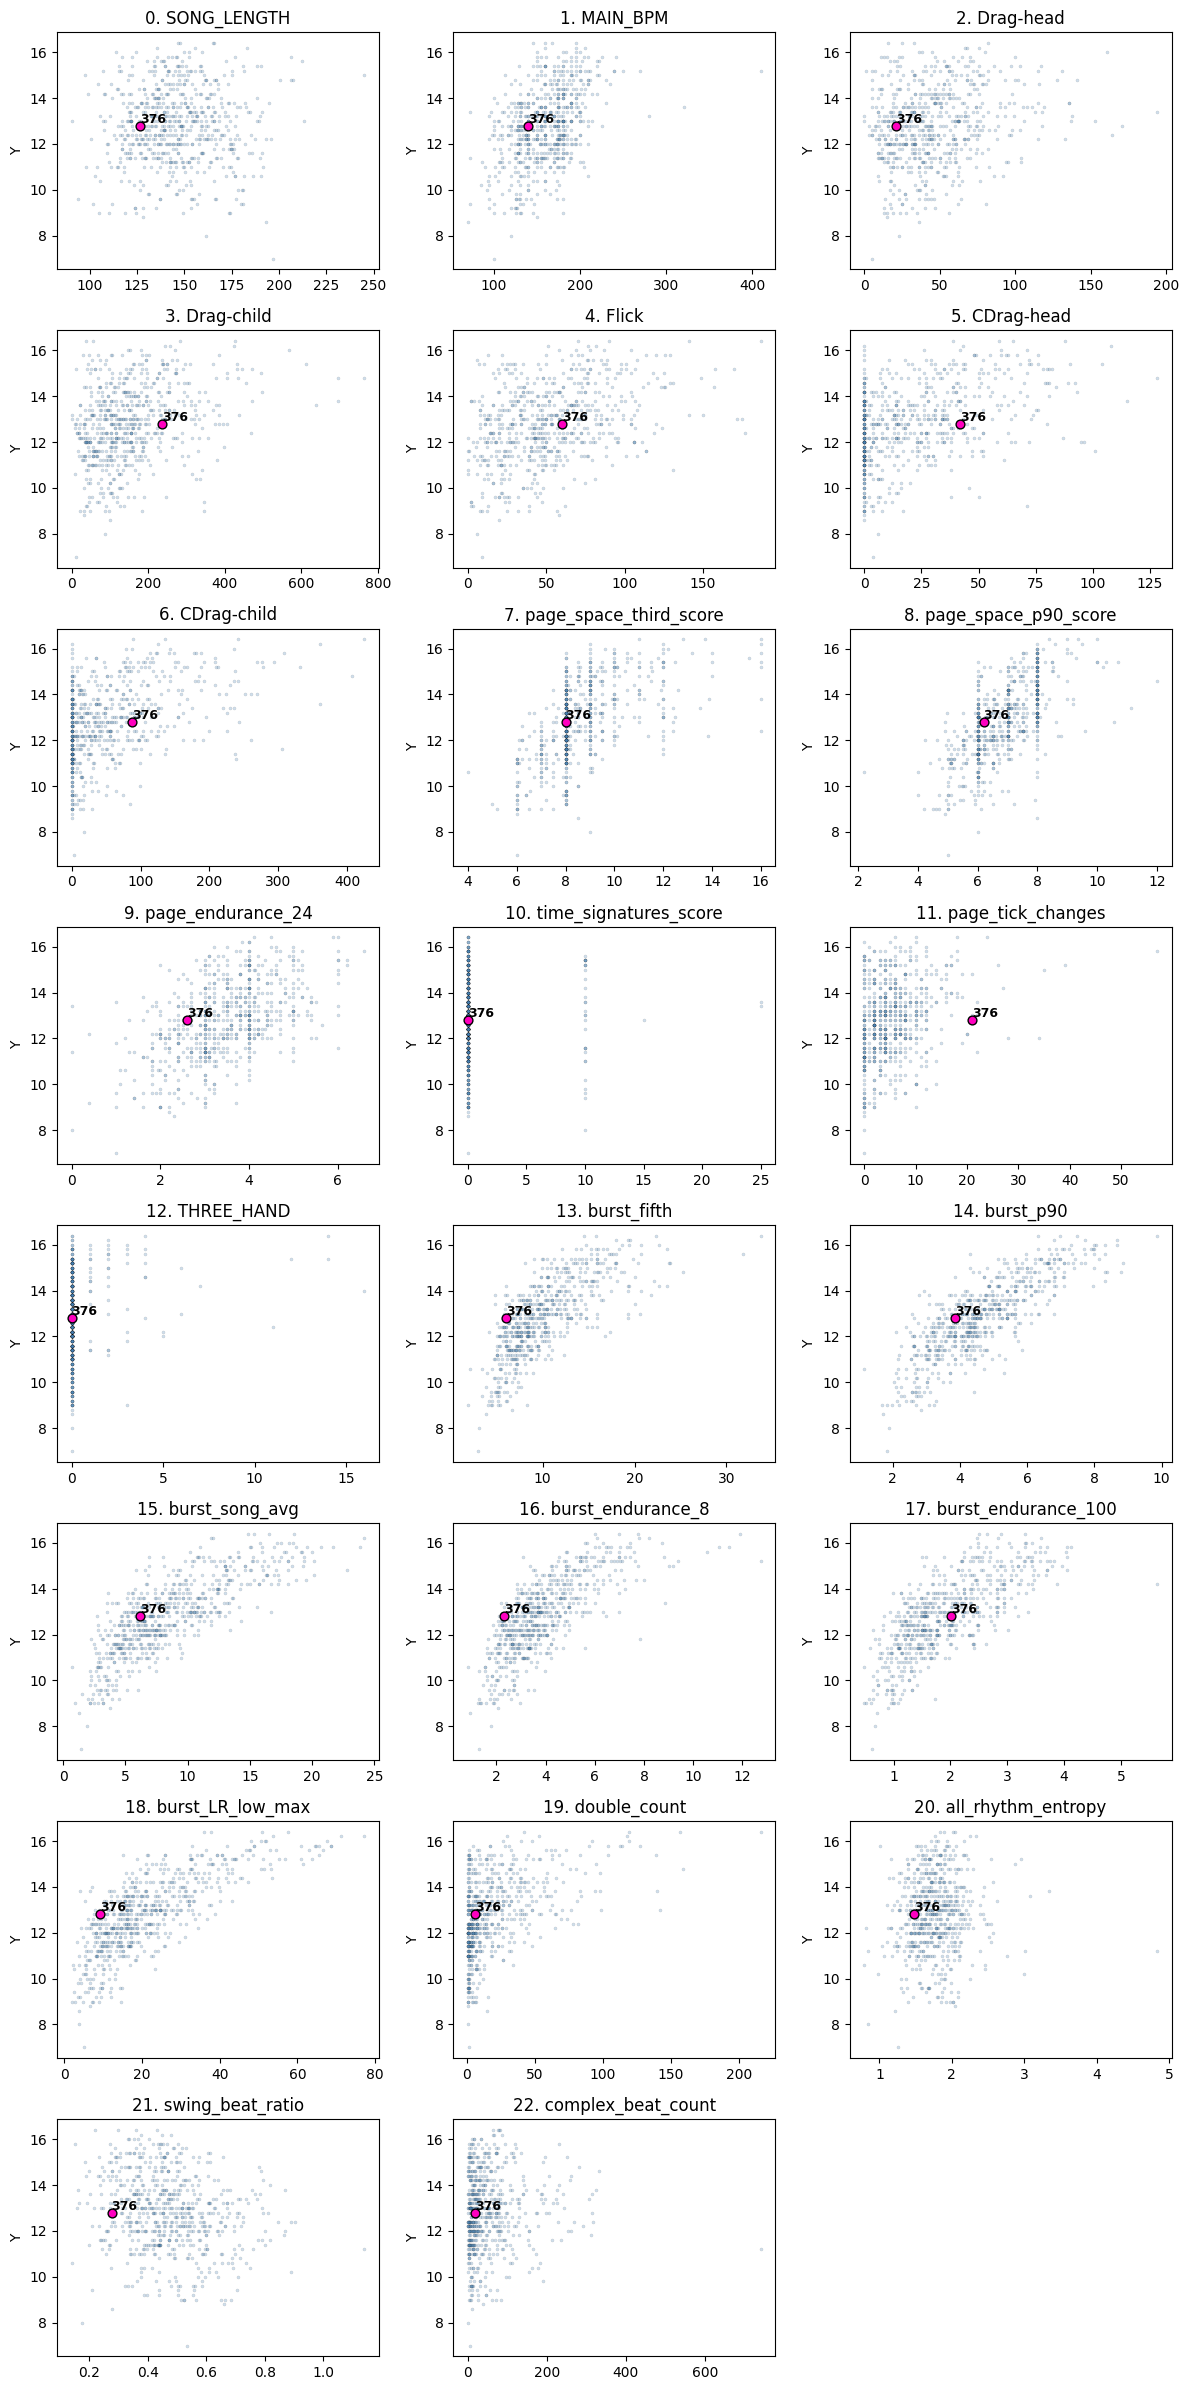

In [25]:
# 特徵跟難度相關性
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 將 X 轉為 DataFrame（列為樣本，欄為特徵）
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

n_features = df.shape[1]
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

highlight_ids = [376]  # 多筆樣本 index
colors = plt.get_cmap("gist_rainbow", len(highlight_ids))

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for h in highlight_ids:
  print(f"{h}\t{all_song_name[h]}")

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    # 全部點
    sns.scatterplot(x=df[col], y=Y, color='steelblue', edgecolor='k', s=5, alpha=0.25)
    # 高亮每個指定的樣本
    for j, idx in enumerate(highlight_ids):
        x_val = df[col].iloc[idx]
        y_val = Y[idx]
        plt.scatter(df[col].iloc[idx], Y[idx],
                    color=colors(j+1), edgecolors='black',
                    s=40, marker='o', label=f"ID {idx}", zorder=10)
        plt.text(x_val, y_val, f"{idx}", fontsize=9, color='black',
                 weight='bold', ha='left', va='bottom')
    plt.title(f"{i}. {feature_name[i]}")
    plt.xlabel("")
    plt.ylabel("Y")

plt.tight_layout()
plt.show()

In [ ]:
# 列出特徵排序
feature_id = 21
arg_sort = np.argsort(X.T[feature_id])
print(feature_name[feature_id])
print()
for i in reversed(arg_sort[:]):
    print(f"{i}\t{pad_display(all_song_name[i][:25], 32)}\t{np.round(X.T[feature_id, i], 3)}\t{Y[i]}")

In [22]:
# 檢視歌曲特徵
n_samples, n_features = X.shape
rank_X = np.zeros_like(X, dtype=int)

for j in range(n_features):
    # 取得該特徵的排序（從小到大）
    sorted_idx = np.argsort(X[:, j])
    # 分配名次：名次從 0 開始 → 最小值是 0，最大值是 n-1
    for rank, i in enumerate(sorted_idx):
        rank_X[i, j] = rank
song_id = 495
print(all_song_name[song_id])
print("Feature Rank")
for i, f_n in enumerate(feature_name):
    print(f"{f_n:<30}\t{len(all_song_name) - rank_X[song_id, i]}")

Elysian Volitation
Feature Rank
SONG_LENGTH                   	152
MAIN_BPM                      	109
Drag-head                     	406
Drag-child                    	272
Flick                         	103
CDrag-head                    	158
CDrag-child                   	206
page_space_third_score        	494
page_space_p90_score          	58
page_endurance_24             	33
time_signatures_score         	378
page_tick_changes             	501
THREE_HAND                    	394
burst_fifth                   	43
burst_p90                     	100
burst_song_avg                	44
burst_endurance_8             	8
burst_endurance_100           	44
burst_LR_low_max              	24
double_count                  	178
all_rhythm_entropy            	480
swing_beat_ratio              	604
complex_beat_count            	573


## RandomForestRegressor

| 加入順序 | 特徵名稱                     | 平均 R²  |
| ---- | ------------------------ | ------ |
| 1    | `burst_p90`              | 0.5520 |
| 2    | `page_space_p90_score`   | 0.7033 |
| 3    | `burst_fifth`            | 0.7471 |
| 4    | `SONG_LENGTH`            | 0.7692 |
| 5    | `complex_beat_count`     | 0.7814 |
| 6    | `burst_song_avg`         | 0.7961 |
| 7    | `page_space_third_score` | 0.8088 |
| 8    | `burst_LR_low_max`       | 0.8125 |
| 9    | `page_tick_changes`      | 0.8142 |
| 10   | `MAIN_BPM`               | 0.8157 |

**最佳平均 R²**：`0.8156595084003785`



| 加入順序 | 特徵名稱                      | 平均 R² 提升後數值 |
| ---- | ------------------------- | ----------- |
| 1    | burst\_p90                | 0.5571      |
| 2    | page\_space\_p90\_score   | 0.6944      |
| 3    | burst\_fifth              | 0.7434      |
| 4    | page\_space\_third\_score | 0.7694      |
| 5    | complex\_beat\_count      | 0.7891      |
| 6    | burst\_endurance\_16      | 0.8007      |
| 7    | CDrag-head                | 0.8087      |
| 8    | Drag-child                | 0.8148      |
| 9    | burst\_song\_avg          | 0.8251      |
| 10   | Drag-head                 | 0.8275      |
| 11   | CDrag-child               | 0.8295      |

**最佳平均 R²：** `0.8295`



| 加入順序 | 特徵名稱                      | 平均 R² 提升後數值 |
| ---- | ------------------------- | ----------- |
| 1    | burst\_p90                | 0.5571      |
| 2    | page\_space\_p90\_score   | 0.6944      |
| 3    | burst\_fifth              | 0.7434      |
| 4    | burst\_endurance\_8       | 0.7699      |
| 5    | complex\_beat\_count      | 0.7918      |
| 6    | page\_space\_third\_score | 0.8045      |
| 7    | CDrag-child               | 0.8118      |
| 8    | Drag-child                | 0.8187      |
| 9    | burst\_song\_avg          | 0.8253      |
| 10   | page\_endurance\_24       | 0.8288      |
| 11   | SONG\_LENGTH              | 0.8312      |
| 12   | all\_rhythm\_entropy      | 0.8322      |

**最佳平均 R²：** `0.8322`

## XGBRegressor

| 加入順序 | 特徵名稱                     | 加入後平均 R² |
| ---- | ------------------------ | -------- |
| 1    | burst_p90              | 0.5997   |
| 2    | page_space_p90_score   | 0.6951   |
| 3    | page_space_third_score | 0.7278   |
| 4    | burst_song_avg         | 0.7570   |
| 5    | complex_beat_count     | 0.7808   |
| 6    | Drag-child             | 0.8054   |
| 7    | burst_LR_low_max       | 0.8167   |
| 8    | double_count           | 0.8225   |
| 9    | SONG_LENGTH            | 0.8284   |
| 10   | burst_endurance_8      | 0.8362   |
| 11   | CDrag-head             | 0.8383   |
| 12   | MAIN_BPM               | 0.8397   |
| 13   | burst_fifth            | 0.8434   |

**最佳平均 R²：** `0.8434`

